In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import opinion_lexicon
nltk.download('opinion_lexicon')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag

[nltk_data] Downloading package opinion_lexicon to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\train.csv\train.csv", header=None)
df.columns = ['sentiment', 'review']

In [23]:
df

,sentiment,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...
...,...,...
559995,2,Ryan was as good as everyone on yelp has claim...
559996,2,Professional \nFriendly\nOn time AND affordabl...
559997,1,Phone calls always go to voicemail and message...
559998,1,Looks like all of the good reviews have gone t...


## **EDA and Preprocessing**

In [24]:
df.dropna(inplace=True)
df.isnull().values.any()


False

In [25]:
total_length = sum(len(text.split()) for text in df['review'])
avg_len = total_length / len(df['review'])
print(f"Average length of reviews: {avg_len}")

Average length of reviews: 133.0288732142857


<Axes: xlabel='sentiment', ylabel='count'>

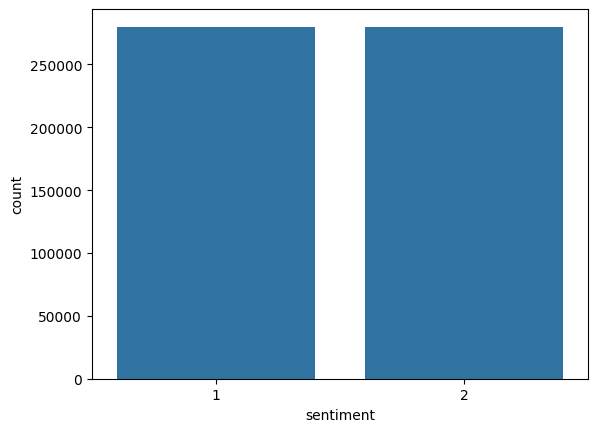

In [26]:
sns.countplot(x='sentiment', data=df)


In [27]:
# change 1 to 0  and 2 to 1
df['sentiment'] = df['sentiment'].replace({2: 1, 1: 0})
df

,sentiment,review
0,0,"Unfortunately, the frustration of being Dr. Go..."
1,1,Been going to Dr. Goldberg for over 10 years. ...
2,0,I don't know what Dr. Goldberg was like before...
3,0,I'm writing this review to give you a heads up...
4,1,All the food is great here. But the best thing...
...,...,...
559995,1,Ryan was as good as everyone on yelp has claim...
559996,1,Professional \nFriendly\nOn time AND affordabl...
559997,0,Phone calls always go to voicemail and message...
559998,0,Looks like all of the good reviews have gone t...


In [28]:
df['sentiment'].value_counts()

0    280000
1    280000
Name: sentiment, dtype: int64

In [29]:
df['review'][2]

"I don't know what Dr. Goldberg was like before  moving to Arizona, but let me tell you, STAY AWAY from this doctor and this office. I was going to Dr. Johnson before he left and Goldberg took over when Johnson left. He is not a caring doctor. He is only interested in the co-pay and having you come in for medication refills every month. He will not give refills and could less about patients's financial situations. Trying to get your 90 days mail away pharmacy prescriptions through this guy is a joke. And to make matters even worse, his office staff is incompetent. 90% of the time when you call the office, they'll put you through to a voice mail, that NO ONE ever answers or returns your call. Both my adult children and husband have decided to leave this practice after experiencing such frustration. The entire office has an attitude like they are doing you a favor. Give me a break! Stay away from this doc and the practice. You deserve better and they will not be there when you really nee

In [30]:
df_clean = df.sample(frac=0.1, random_state=42)
df_clean = df_clean.reset_index(drop=True)
df_clean

,sentiment,review
0,1,This place is one of my favorite comic shops. ...
1,0,The wait time for an appointment is ridiculous...
2,0,I did not like this hotel at all. It's very ol...
3,1,Mill Avenue has a serious issue with parking. ...
4,1,Favorite sushi place in NV! Price is reasonab...
...,...,...
55995,1,It's time for an update of CVS -\n\nIf you are...
55996,0,"I was in the area doing some shopping, and bot..."
55997,0,I did an all Venetian restaurant tour on my mo...
55998,1,"Great atmosphere, good food, profesional servi..."


<Axes: xlabel='sentiment', ylabel='count'>

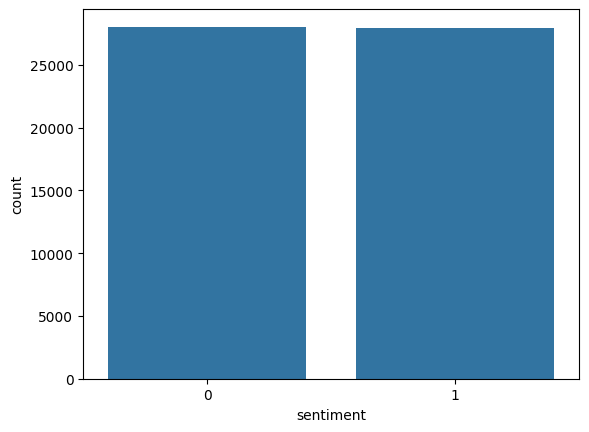

In [31]:
sns.countplot(x='sentiment', data=df_clean)


## **PREPROCESS TEXT**

In [32]:
# Contraction expansion function
def expand_contractions(text: str) -> str:
    contractions = {
        "don't": 'do not', "can't": 'cannot', "won't": 'will not', "isn't": 'is not',
        "aren't": 'are not', "wasn't": 'was not', "weren't": 'were not', "hasn't": 'has not',
        "haven't": 'have not', "hadn't": 'had not', "doesn't": 'does not', "didn't": 'did not',
        "shouldn't": 'should not', "couldn't": 'could not', "wouldn't": 'would not', "mightn't": 'might not',
        "mustn't": 'must not', "needn't": 'need not'
    }
    
    for contraction, expanded in contractions.items():
        text = text.replace(contraction, expanded)
    return text


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')# identify special symbol
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')# identify bad symbol
NEGATIVE_WORDS = set(opinion_lexicon.negative())
POSITIVE_WORDS = set(opinion_lexicon.positive())
def preprocess_rating_text(review):
    # remove noise data
    review = str(review).lower()
    review = expand_contractions(review)
    review = REPLACE_BY_SPACE_RE.sub(' ', review)
    review = BAD_SYMBOLS_RE.sub('', review)
    review = re.sub(r'https*\S+', ' ', review)  # Remove URLs
    review = re.sub(r'[@#]\S+', ' ', review)   # Remove mentions and hashtags
    review = re.sub('<.*?>', '', review)       # Remove HTML tags
    tokenizer = word_tokenize(review)
    stop_words = set(stopwords.words('english')) - NEGATIVE_WORDS - POSITIVE_WORDS
    tokens = [token for token in tokenizer if token not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    tagged_tokens = pos_tag(tokens)
    # Extract key words
    processed_tokens = [
        word.lower() if tag in ('JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS', 'VBD', 'VBG', 'RBS') else word
        for word, tag in tagged_tokens
        if not (tag == ('VBZ','VBG'))
    ]
    
    processed_review = ' '.join(processed_tokens)
    return processed_review

In [34]:
df_clean['review'] = df_clean['review'].apply(preprocess_rating_text)


In [35]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  56000 non-null  int64 
 1   review     56000 non-null  object
dtypes: int64(1), object(1)
memory usage: 875.1+ KB


In [36]:
df_clean.isnull().sum().any()

False

In [37]:
df_clean

,sentiment,review
0,1,place one favorite comic shop actually live cl...
1,0,wait time appointment ridiculous waiting hour ...
2,0,like hotel old comfort nthe good thing cheap t...
3,1,mill avenue serious issue parking fan various ...
4,1,favorite sushi place nv price reasonable food ...
...,...,...
55995,1,time update cv nnif using extra care card util...
55996,0,area shopping man decided time eat unfortunate...
55997,0,venetian restaurant tour recent vega trip dinn...
55998,1,great atmosphere good food profesional service...


In [38]:
total_length = sum(len(text.split()) for text in df_clean['review'])
avg_len = total_length / len(df_clean['review'])
print(f"Average length of reviews after cleaning: {avg_len}")

Average length of reviews after cleaning: 68.13325


## **ENCODING TEXT FOR MODEL**

In [39]:
import tensorflow as tf
print(tf.__version__)
print("TensorFlow is working!")


2.15.0
TensorFlow is working!


In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
import joblib as jb

In [41]:
train_data, test_data = train_test_split(df_clean, test_size=0.2, random_state=42)

In [42]:
maxlen = 200
num_words = 5000

In [43]:
tokenizer_rating = Tokenizer(num_words=num_words)
tokenizer_rating.fit_on_texts(train_data["review"])
X_train = pad_sequences(tokenizer_rating.texts_to_sequences(train_data["review"]), maxlen=maxlen)
X_test = pad_sequences(tokenizer_rating.texts_to_sequences(test_data["review"]), maxlen=maxlen)

In [44]:
jb.dump(tokenizer_rating,'tokenizer_rating.pkl')

['tokenizer_rating.pkl']

In [45]:
y_train = train_data["sentiment"]
y_test = test_data["sentiment"]

## **TEST LSTM MODEL**

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, Bidirectional, LSTM, GlobalMaxPooling1D, Dense, BatchNormalization,Dropout ,  Conv1D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau   
import tensorflow as tf


In [47]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation="sigmoid"))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [48]:
lstm_model_history = lstm_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)


Epoch 1/5


560/560 [==============================] - 118s 206ms/step - loss: 0.3098 - accuracy: 0.8670 - val_loss: 0.2458 - val_accuracy: 0.9022
Epoch 2/5
560/560 [==============================] - 154s 275ms/step - loss: 0.2133 - accuracy: 0.9183 - val_loss: 0.2422 - val_accuracy: 0.9040
Epoch 3/5
560/560 [==============================] - 125s 223ms/step - loss: 0.1783 - accuracy: 0.9317 - val_loss: 0.2521 - val_accuracy: 0.9052
Epoch 4/5
560/560 [==============================] - 140s 249ms/step - loss: 0.1524 - accuracy: 0.9426 - val_loss: 0.2626 - val_accuracy: 0.9030
Epoch 5/5
560/560 [==============================] - 106s 190ms/step - loss: 0.1348 - accuracy: 0.9501 - val_loss: 0.2737 - val_accuracy: 0.9027


In [49]:
test_lstm_results = lstm_model.evaluate(X_test, y_test, verbose=1)

print('\nTest Set Results:')
print(f'Loss: {test_lstm_results[0]:.3f}')
print(f'Accuracy: {test_lstm_results[1]:.3f}')


350/350 [==============================] - 10s 29ms/step - loss: 0.2664 - accuracy: 0.9039

Test Set Results:
Loss: 0.266
Accuracy: 0.904


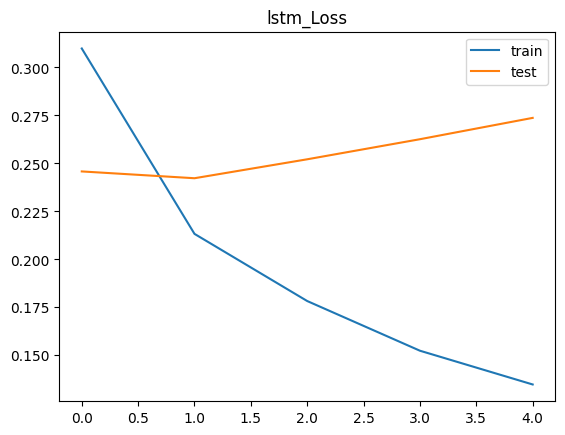

In [50]:
plt.title('lstm_Loss')
plt.plot(lstm_model_history.history['loss'], label='train')
plt.plot(lstm_model_history.history['val_loss'], label='test')
plt.legend()
plt.show()

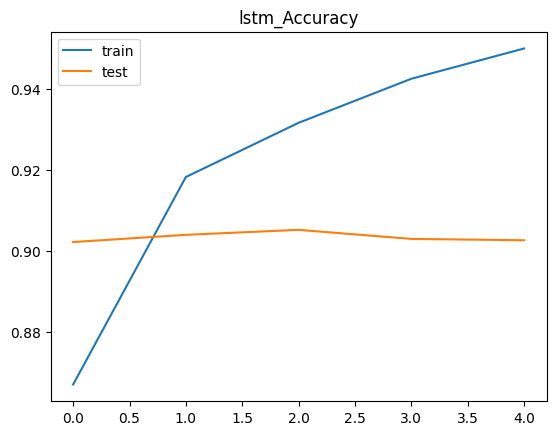

In [51]:
plt.title('lstm_Accuracy')
plt.plot(lstm_model_history.history['accuracy'], label='train')
plt.plot(lstm_model_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [52]:
jb.dump(lstm_model, 'lstm_model_rating.pkl')

['lstm_model_rating.pkl']

## **TEST CNN MODEL**

In [66]:
import onnxruntime
print(onnxruntime.__version__)

ImportError: DLL load failed while importing onnxruntime_pybind11_state: A dynamic link library (DLL) initialization routine failed.

In [53]:
# cnn_model = Sequential()
# cnn_model.add(Embedding(input_dim=num_words, output_dim=128, input_length=maxlen))
# cnn_model.add(SpatialDropout1D(0.2))
# cnn_model.add(Conv1D(128, 5, padding = 'same',activation='relu'))
# cnn_model.add(GlobalMaxPooling1D())
# cnn_model.add(Dropout(0.2))
# cnn_model.add(Dense(1, activation='sigmoid'))
# cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# history_cnn_model = cnn_model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

In [54]:
# test_cnn_results = cnn_model.evaluate(X_test, y_test, verbose=1)

# print('\nTest Set Results:')
# print(f'Loss: {test_cnn_results[0]:.3f}')
# print(f'Accuracy: {test_cnn_results[1]:.3f}')

In [55]:
# plt.title('cnn_Loss')
# plt.plot(history_cnn_model.history['loss'], label='train')
# plt.plot(history_cnn_model.history['val_loss'], label='test')
# plt.legend()
# plt.show()

In [56]:
# plt.title('cnn_accuracy')
# plt.plot(history_cnn_model.history['accuracy'], label='train')
# plt.plot(history_cnn_model.history['val_accuracy'], label='test')
# plt.legend()
# plt.show()

In [57]:
# jb.dump(cnn_model, 'cnn_model_rating.pkl')

## **TEST HYBRID MODEL(LSTM+CNN)**

In [58]:
from tensorflow.keras.regularizers import l2

In [59]:
hybrid_model = Sequential([
    Embedding(input_dim=num_words, output_dim=128, input_length=maxlen),
    SpatialDropout1D(0.2),
    # Bidirectional LSTM Layer
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),
    # 1D Convolutional Layer
    Conv1D(128, 5, padding='same', activation='relu'),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    # Dense Layers
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.2),
    # Output Layer
    Dense(1, activation='sigmoid') 
])

hybrid_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]


In [60]:
hybrid_history = hybrid_model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/5
560/560 [==============================] - 155s 270ms/step - loss: 1.1625 - accuracy: 0.8475 - val_loss: 0.4576 - val_accuracy: 0.8978 - lr: 0.0010
Epoch 2/5
560/560 [==============================] - 153s 274ms/step - loss: 0.2826 - accuracy: 0.9117 - val_loss: 0.2577 - val_accuracy: 0.9041 - lr: 0.0010
Epoch 3/5
560/560 [==============================] - 153s 273ms/step - loss: 0.1985 - accuracy: 0.9252 - val_loss: 0.2484 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 4/5
560/560 [==============================] - 302s 540ms/step - loss: 0.1671 - accuracy: 0.9385 - val_loss: 0.2539 - val_accuracy: 0.9067 - lr: 0.0010
Epoch 5/5
560/560 [==============================] - 438s 784ms/step - loss: 0.1419 - accuracy: 0.9484 - val_loss: 0.2850 - val_accuracy: 0.8971 - lr: 0.0010


In [61]:
test_hybrid_results = hybrid_model.evaluate(X_test, y_test, verbose=1)

print('\nTest Set Results:')
print(f'Loss: {test_hybrid_results[0]:.3f}')
print(f'Accuracy: {test_hybrid_results[1]:.3f}')

350/350 [==============================] - 15s 40ms/step - loss: 0.2834 - accuracy: 0.8979

Test Set Results:
Loss: 0.283
Accuracy: 0.898


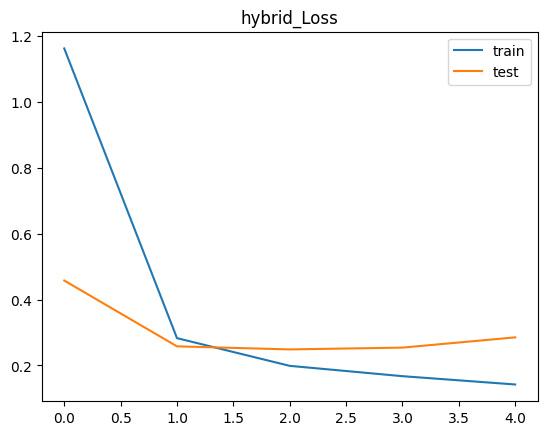

In [62]:
plt.title('hybrid_Loss')
plt.plot(hybrid_history.history['loss'], label='train')
plt.plot(hybrid_history.history['val_loss'], label='test')
plt.legend()
plt.show()

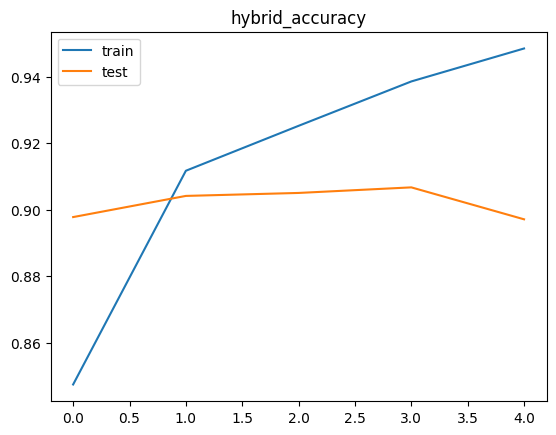

In [63]:
plt.title('hybrid_accuracy')
plt.plot(hybrid_history.history['accuracy'], label='train')
plt.plot(hybrid_history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [64]:
jb.dump(hybrid_model, 'hybrid_model_rating.pkl')

['hybrid_model_rating.pkl']

In [65]:
prediction = hybrid_model.predict(X_test)
prediction

350/350 [==============================] - 17s 46ms/step


array([[6.0758786e-04],
       [9.7792000e-01],
       [3.7959270e-02],
       ...,
       [5.4517324e-04],
       [6.0002815e-02],
       [4.0253773e-03]], dtype=float32)

## **=> CHOOSING Hybrid_model AS THE BEST MODEL**

## **TEST WITH DATASET**

In [50]:
hybrid_model = jb.load("hybrid_model_rating.pkl")
cnn_model = jb.load("cnn_model_rating.pkl")
lstm_model = jb.load("lstm_model_rating.pkl")
tokinizer_rating = jb.load("tokenizer_rating.pkl")
test_df = pd.read_csv(r"C:\Users\AD\Desktop\Data projects\python\Decision-making-system\Data\review.csv")
test_df.tail()

,review_id,Review
195,NaN,The science book explains concepts in a simple...
196,NaN,The toaster makes perfect golden-brown toast e...
197,NaN,The projector produces a bright and clear imag...
198,NaN,The bookshelf is decent but came with missing ...
199,NaN,The dining set arrived with scratches on the s...


In [51]:
def calculate_rating(ratings):
    return [max(0.5, round(rating * 5 * 2) / 2) for rating in ratings]

In [52]:
sequences = tokenizer_rating.texts_to_sequences(test_df["Review"])
padded_sequences = pad_sequences(sequences, maxlen=200)

In [53]:
ratings = hybrid_model.predict(padded_sequences)
processed_ratings = calculate_rating(ratings.flatten())  
test_df["Predicted_Rating"] = processed_ratings
test_df

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


,review_id,Review,Predicted_Rating
0,NaN,The self-help book is very insightful and help...,5.0
1,NaN,"The fan is powerful yet quiet, a perfect combi...",5.0
2,NaN,The winter coat is warm and looks amazing!,4.5
3,NaN,The gaming console has top-notch graphics and ...,4.5
4,NaN,The display started flickering after a week. V...,2.5
...,...,...,...
195,NaN,The science book explains concepts in a simple...,4.5
196,NaN,The toaster makes perfect golden-brown toast e...,5.0
197,NaN,The projector produces a bright and clear imag...,2.0
198,NaN,The bookshelf is decent but came with missing ...,0.5


In [54]:
test_df.to_csv("review_rating.csv", index=False)